# Create a custom simulation for Burkina Faso

## 1. Import required packages

In [1]:
import covasim as cv
import numpy as np

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


## 2. Define parameters and country for base model

In [2]:
pars = dict(
    pop_type = 'hybrid', # see documentation - this is a hybrid between random and a data derived model. Later, develop synthpop
    pop_size = 100e3,  # population of the DRC is 20 million. Note that when I despecify this, it goes down to 20,000 people 
    pop_scale= 20, # one agent represents 20 people 
    location = 'Burkina Faso',
    start_day = '2020-04-01',
    end_day = '2020-12-31',
    contacts=dict(h=6, s=6, w=5, c=6), 
    verbose = 0 # means it won't print all the output 
)


# other things you can re-define in pars include n_days, beta  (As below)
# contacts taken from Polymod data (see Onedrive matrix: privileged link 
# https://worldbankgroup-my.sharepoint.com/:x:/r/personal/sayling_worldbank_org1/Documents/DIME%20-%20ABM/2.%20Burkina%20Faso/Interaction%20Matrices/burkina_faso_contact_matrix_polymod_121620.xlsx?d=w8ce791d246f54b36a66232acaf2857ea&csf=1&web=1&e=NMb0Eu)

## 3. Take a look at population characteristics from input data (of country (location) as defined above)

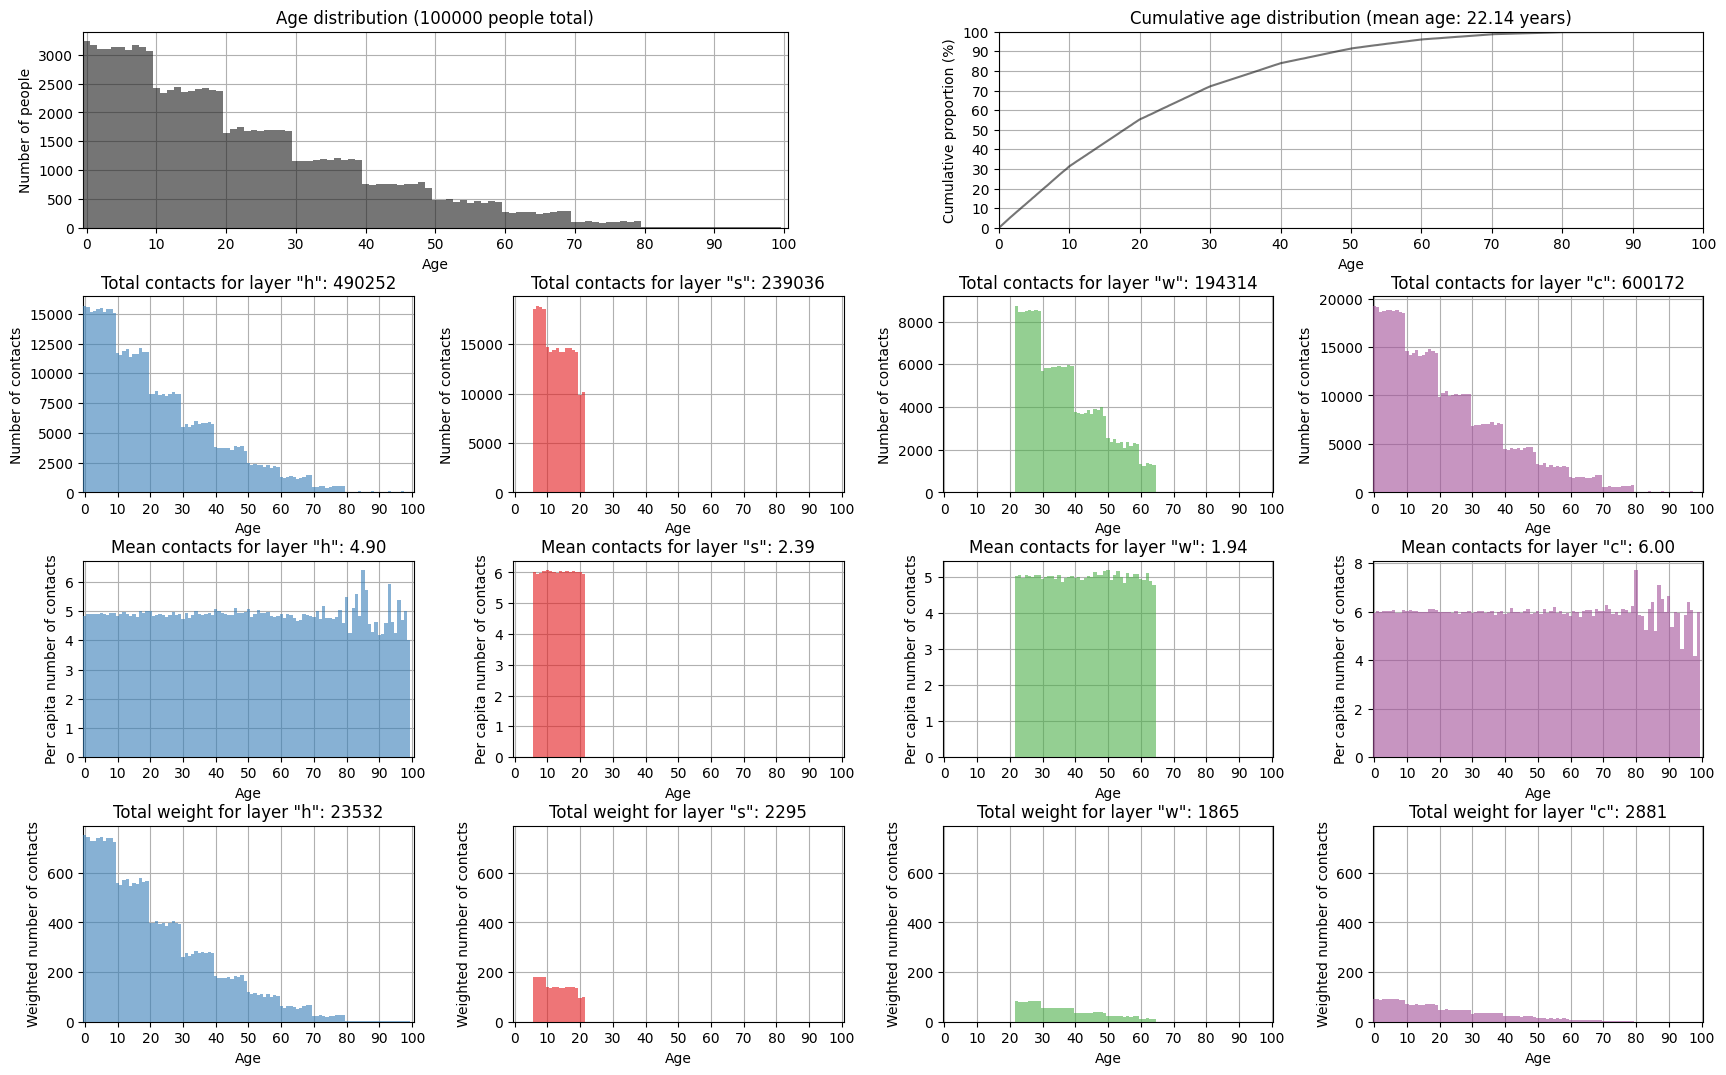

In [3]:
cv.options.set(dpi=100, show=False, close=True) #, verbose=0 # ) # put back in verbose once i've figured out what this does

# change the transmission rate (default beta value is 0.016?)
#cb = cv.change_beta(days=['2020-03-01'], changes=[1.5])  # days=['2020-04-06'],
# date that lockdown was imposed -- but would need to see how it impacted case numbers and compare
#sim = cv.Sim(pars, interventions=cb, label='With changes in RO from 6th April')
sim = cv.Sim(pars)
sim.initialize()
fig = sim.people.plot()

## 4. Run base simulation

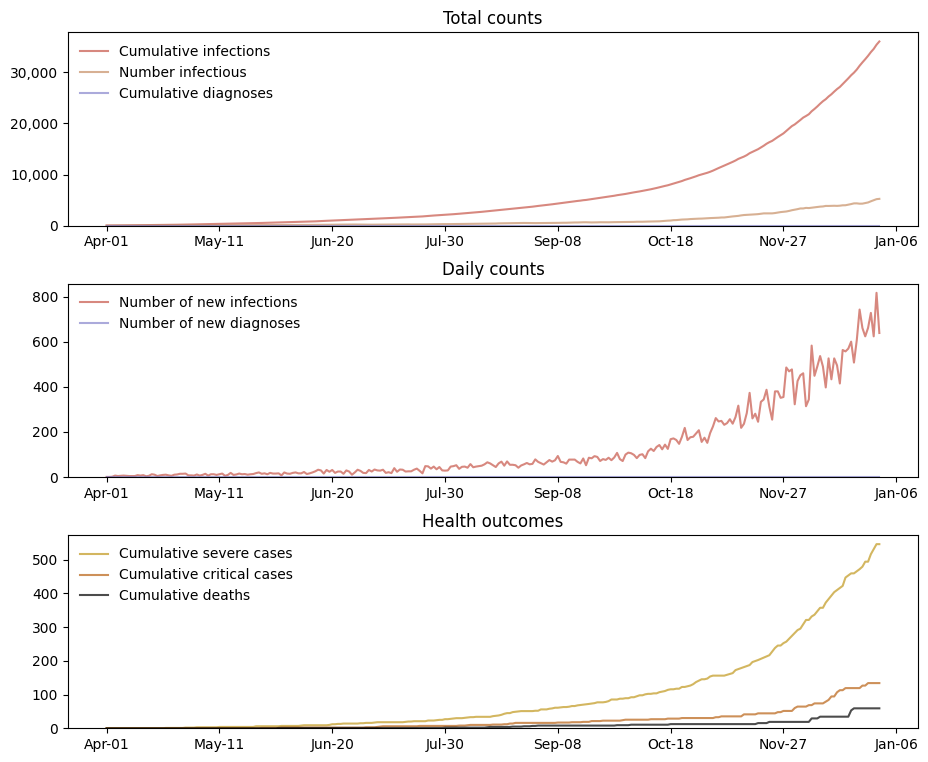

In [4]:
# just take a look at how changing beta changes the trajectory 
sim.run()
scenariofig = sim.plot()  #  this will only work if I run sim.run() not msim.run()
sim.plot()

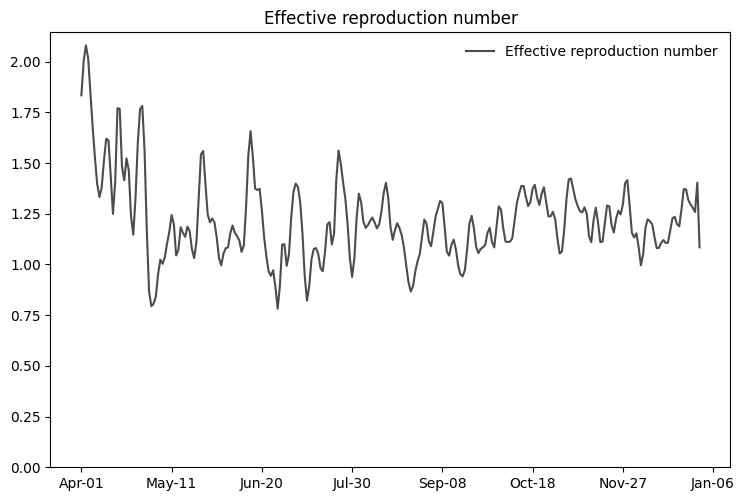

In [5]:
# take a look at the r value 
sim.plot_result('r_eff')

## 4. Define comparative vaccination scenarios 

In [6]:
def no_intervention(sim):
    elderly = sim.people.age >65

## a. Vaccinate 100% of over 65s only

In [7]:
def vaccinate_over65s(sim): # this is for any vaccination
   # if sim.t == sim.day('2020-04-15'): # i'm setting a situation where vaccination is introduced for all this age group on 15th
      #  elderly = sim.people.age >65
      # sim.people.rel_sus[elderly] = 0.1 
   # if sim.t == sim.day('2020-04-15'): # i'm setting a situation where vaccination is introduced for all this age group on 15th
        young  = cv.true(sim.people.age < 14) # cv.true() returns indices of people matching this condition, i.e. people under 14
        middle = cv.true((sim.people.age >= 15) * (sim.people.age < 65))
        old = cv.true(sim.people.age >=65)
        inds = sim.people.uid
        vals=np.ones(len(sim.people))
        vals[young] = 0.0
        vals[middle] = 0.0
        vals[old]=1.0
        output = dict(inds=inds, vals=vals)
        return output
        # and it reduces their chances of severe disease by 90%
        
# define as vaccine strategy one
vaccine_s1 = cv.vaccine(days=20, rel_sus=0.1, rel_symp=0.6, subtarget=vaccinate_over65s )


## b. Vaccinate only a proportion of the most mobile (15-65 yrs)

In [8]:
def vaccinate_15_65(sim): # this is for any vaccination
   # if sim.t == sim.day('2020-04-15'): # i'm setting a situation where vaccination is introduced for all this age group on 15th
        young  = cv.true(sim.people.age < 14) # cv.true() returns indices of people matching this condition, i.e. people under 14
        middle = cv.true((sim.people.age >= 15) * (sim.people.age < 65))
        old = cv.true(sim.people.age >=65)
        inds = sim.people.uid
        vals=np.ones(len(sim.people))
        vals[young] = 0.0
        vals[middle] = 0.125 # because of the number of population in this age category, in this scenario, the same number of vaccines could only reach 12.5% of this age group
        vals[old]=0.0
        output = dict(inds=inds, vals=vals)
        return output
        # and it reduces their chances of severe disease by 90%
        
#define this as vaccine strategy two 
vaccine_s2 = cv.vaccine(days=20, rel_sus=0.1, rel_symp=0.6, subtarget=vaccinate_15_65)
### in reality, i don't think this can be called, because 'vaccine' is a specific name as below

## c. Vaccinate 100% of the oldest and the remainder to small % of younger generations

In [9]:
# Define the vaccine subtargeting
def vaccinate_by_age(sim):
    young  = cv.true(sim.people.age < 14) # cv.true() returns indices of people matching this condition, i.e. people under 14
    middle = cv.true((sim.people.age >= 15) * (sim.people.age < 65))
    old = cv.true(sim.people.age >=65)
    inds = sim.people.uid
    vals=np.ones(len(sim.people))
    
    vals[young] = 0.025 # 2.5 % of people <14
    vals[middle] = 0.025 # 2.5 %  of people 15-65
    vals[old] = 1.0 # 100% of people >65
    output = dict(inds=inds, vals=vals)
    return output

# Define the vaccine strategy one
vaccine_s3 = cv.vaccine(days=20, rel_sus=0.1, rel_symp=0.6, subtarget=vaccinate_by_age )


## 5. Run simulation with scenarios included

In [10]:
sim1 = cv.Sim(pars, interventions=no_intervention, label = 'No vaccine')
sim2 = cv.Sim(pars, interventions=vaccine_s1, label = 'Vaccinate over 65s')
sim3 = cv.Sim(pars, interventions=vaccine_s2, label = 'Vaccinate 15-65s')
sim4 = cv.Sim(pars, interventions=vaccine_s3, label = 'Vaccinate subgroups')
msim = cv.MultiSim([sim1, sim2, sim3, sim4])
msim.run()


## 6. Plot results 

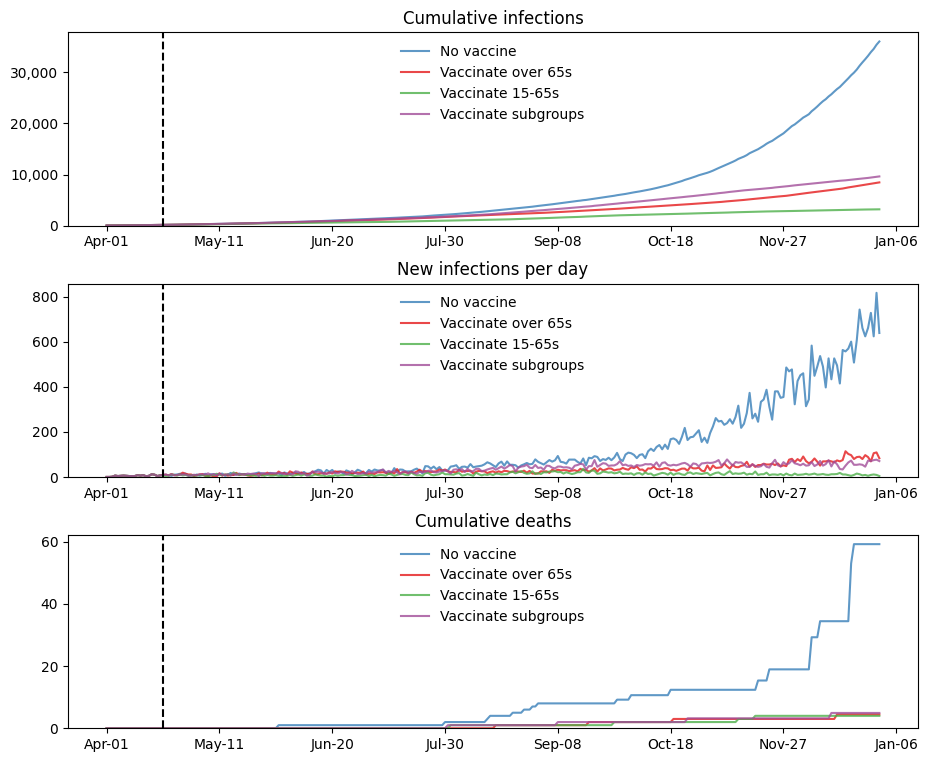

In [11]:
fig2 = msim.plot(to_plot= ['cum_deaths', 'new_infections'])
# plots different scenarios against one another
msim.plot()

## 7. Save output

In [12]:
sim.initialize()
sim.run()
sim.save('../outputs/bf-sim_novaccine.sim')
sim.to_excel('../outputs/bf-sim_novaccine.xlsx')

Object saved to /Users/sophieayling/Documents/GitHub/covasim/my_countries/BF/outputs/bf-sim_novaccine.xlsx.


In [13]:
sim2.initialize()
sim2.run()
sim2.save('../outputs/bf-sim_vaccinate65s.sim')
sim2.to_excel('../outputs/bf-sim_vaccinate65s.xlsx')

Object saved to /Users/sophieayling/Documents/GitHub/covasim/my_countries/BF/outputs/bf-sim_vaccinate65s.xlsx.


In [14]:
sim3.run()
sim3.save('../outputs/bf-sim_vaccinate_15-65s.sim')
sim3.to_excel('../outputs/bf-sim_vaccinate_15-65s.xlsx')

Object saved to /Users/sophieayling/Documents/GitHub/covasim/my_countries/BF/outputs/bf-sim_vaccinate_15-65s.xlsx.


In [15]:
sim4.run()
sim4.save('../outputs/bf-sim_vaccinate_subgroups.sim')
sim4.save('../outputs/bf-sim_vaccinate_subgroups.xlsx')

'/Users/sophieayling/Documents/GitHub/covasim/my_countries/BF/outputs/bf-sim_vaccinate_subgroups.xlsx'

In [18]:
!jupyter nbconvert BF_vaccination_strategies.ipynb --to html --output BF_vaccination_strategies.html

[NbConvertApp] Converting notebook BF_vaccination_strategies.ipynb to html
[NbConvertApp] Writing 1076132 bytes to BF_vaccination_strategies.html


In [17]:
filename = '../outputs/retro_scenarios.png'
cv.savefig(filename) # Save including version information
cv.get_png_metadata(filename) # Retrieve and print information

# for some reason this is still blank

Covasim version: 2.0.2
Covasim branch: master
Covasim hash: 97391dd
Covasim date: 2021-05-13 18:32:03 UTC
Covasim caller branch: master
Covasim caller hash: 97391dd
Covasim caller date: 2021-05-13 18:32:03 UTC
Covasim caller filename: /Users/sophieayling/Documents/GitHub/covasim/covasim/misc.py
Covasim current time: 2021-May-17 23:31:57
Covasim calling file: <ipython-input-17-c41b54620037>, line 2


<Figure size 600x400 with 0 Axes>